In [2]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha)
from settings import (plot_lower, plot_upper, stats_frac_lower,
                      stats_frac_upper, select_lower, select_upper,
                      p_lower, p_upper, stats_frac_middle, title_pad, ci)

In [3]:
exp = "10"
base_path = f"/storage/noise_correlations/exp{exp}"

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

# Extra datasets
# pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
# pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

# Extra datasets
# pvc11_2 = h5py.File(pvc11_2_path, 'r')
# pvc11_3 = h5py.File(pvc11_3_path, 'r')

In [6]:
n_max_units = ret2['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [7]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'Observed',
    'Shuffle',
    'UC',
    'FA'
]

percentile_groups = [
    'p_s_lfi',
    'p_u_lfi',
    'p_fa_lfi'
]
value_groups = [
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
lfi_models = [
    'observed',
    'shuffle',
    'uniform',
    'fa'
]
models = [
    'shuffle',
    'uniform',
    'fa'
]
labels2 = [
    'Shuffle',
    'UC',
    'FA'
]
T = np.array([114, 200, 60])[:, np.newaxis]
N = dims[np.newaxis]
dtheta = np.array([np.mean(np.diff(np.unique(ret2['stimuli'][:]))),
                   np.mean(np.diff(np.unique(pvc11_1['stimuli'][:]))),
                   np.mean(np.diff(np.log(np.unique(ecog['stimuli'][:]))))])[:, np.newaxis]
c0s = (2. * T - N - 3.) / (2. * T - 2)
c1s = (2. * N) / (T * dtheta**2)

In [8]:
median_lfis = dict()
for idx, (result, c0, c1) in enumerate(zip(results, c0s, c1s)):
    c0 = c0[:, np.newaxis]
    c1 = c1[:, np.newaxis]
    # Plot observed LFI
    for group, model in zip(groups, lfi_models):
        if group == 'v_lfi':
            median_lfis[(idx, group)] = result[group][:] * c0 - c1
        else:
            median_lfis[(idx, group)] = np.median(result[group], axis=2) * c0 - c1
            # Alternative: take statistics across all dim-stims and repeats
            # values = np.reshape(result[group], (dims.size, -1))

In [9]:
lmus_lfi = dict()
lmus_p = dict()
for idx in range(len(results)):
    print(idx)
    # Plot observed LFI
    for group in groups:
        values = median_lfis[(idx, group)]
        lmus_lfi[(idx, group)] = utils.run_bootstrap(values, np.median, ci).T
        
    for group in percentile_groups:
        # Calculate median and bounds for each null model
        percentiles = results[idx][group][:]
        lmus_p[(idx, group)] = utils.run_bootstrap(percentiles, np.median, ci).T

0
1
2


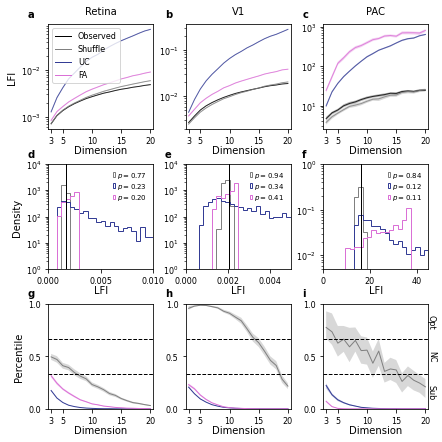

In [11]:
"""
Figure Settings
"""
# Label adjustments
subplot_x = -0.18
subplot_y = 1.12
# Legend settings
handlelength = 0.3
handletextpad = 0.3
# Percentile bounds for curves
bins = [
    np.linspace(0., 0.01, 25),
    np.linspace(0., 0.005, 25),
    np.linspace(0, 2, 25)
]
bins = [
    np.linspace(0., 0.01, 25),
    np.linspace(0., 0.005, 25),
    np.linspace(0, 45, 25)
]
qs = [stats_frac_lower, stats_frac_middle, stats_frac_upper]
"""
Figure 3
"""
figsize = (6, 6)
fig = plt.figure(figsize=figsize)
te = .05
be = .06
le = .095
hg = .075
vg = .08
h = (1. - te - be - 2*vg) / 3.
w = h * figsize[1] / figsize[0]
shg = .05
re = 1. - le - 3*w - 2*hg - shg

axes = np.empty((3, 3), dtype=object)
for ii in range(3):
    for jj in range(3):
        axes[ii, jj] = fig.add_axes([le + jj*(hg + w), be + (2-ii)*(h+vg), w, h])

"""
First Row: LFI values over dimension
"""
# Enumerate over results
for idx, (result, ax) in enumerate(zip(results, axes[0])):
    # Plot observed LFI
    for group, model in zip(groups, lfi_models):
        color = colors[model]
        lower, median, upper = lmus_lfi[(idx, group)]
        # Fill region between percentile bounds
        ax.fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=color,
            alpha=fill_alpha,
            ec='none')
        ax.plot(
            dims,
            median,
            linewidth=lw,
            color=color,
            alpha=line_alpha)

# Set bounds
#axes[0, 0].set_ylim(bottom=5e-4, top=1e-1)
#axes[0, 1].set_ylim(bottom=1e-3)
#axes[0, 2].set_ylim(bottom=3, top=1e3)

# Set axis limits, scales, and labels
for (ax, title) in zip(axes[0], titles):
    ax.set_xlim([2.5, 20.5])
    ax.set_yscale('log')
    ax.set_xticks([3, 5, 10, 15, 20])
    
    ax.set_xlabel(r'Dimension', fontsize=ax_label_size, labelpad=0)
    ax.set_title(title, fontsize=ax_label_size, pad=title_pad)
axes[0, 0].set_ylabel(r'LFI', fontsize=ax_label_size)

"""
Second Row: Example distributions
"""
dim_idx = 0
dimstim_idxs = [4044, 2011, 1766]
dimstim_idxs = [0, 7, 2]

for idx, result in enumerate(results):
    dimstim_idx = dimstim_idxs[idx]
    lfi = result['v_lfi'][dim_idx, dimstim_idx]
    
    axes[1, idx].axvline(
        lfi,
        color='black',
        lw=lw)

    for (v_group, p_group, model) in zip(value_groups, percentile_groups, models):
        values = result[v_group][dim_idx, dimstim_idx]
        axes[1, idx].hist(
            values,
            color=colors[model],
            histtype='step',
            linewidth=lw,
            bins=bins[idx],
            density=True,
            label=f'$p={result[p_group][dim_idx, dimstim_idx]:0.2f}$')
        
# Set bounds
for ii in range(3):
    axes[1, ii].set_xlim([bins[ii][0], bins[ii][-1]])

#axes[1, 0].set_xticks([0.0012, 0.0016, 0.0020])
#axes[1, 1].set_xticks([0.0007, 0.0010, 0.0013])
#axes[1, 2].set_xticks([0, 2, 4, 6, 8])

axes[1, 0].set_yscale('log')
axes[1, 0].set_ylim([1, 1e4])
axes[1, 1].set_yscale('log')
axes[1, 1].set_ylim([1, 1e4])
axes[1, 2].set_yscale('log')
axes[1, 2].set_ylim([5e-3, 1e0])
axes[1, 0].set_xticks([0, .005, .01])
axes[1, 1].set_xticks([0, .002, .004])
axes[1, 2].set_xticks([0, 20, 40])

#axes[1, 0].set_yticks([0, 100, 200])
#axes[1, 1].set_yticks([0, 100, 200])
#axes[1, 2].set_yticks([0, 200, 400, 600])

for ax in axes[1]:
    ax.tick_params(labelsize=tick_label_size)
    ax.set_xlabel(r'LFI', fontsize=ax_label_size, labelpad=0)
axes[1, 0].set_ylabel(r'Density', fontsize=ax_label_size)

"""
Third Row
"""
# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model in zip(percentile_groups, models):
        # Calculate median and bounds for each null model
        lower, median, upper = lmus_p[(idx, group)]
        # Fill region between percentile bounds
        axes[2, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha,
            ec='none')
        axes[2, idx].plot(
            dims,
            median,
            linewidth=lw,
            color=colors[model])
    axes[2, idx].axhline(plot_lower, 0, 1, lw=lw, ls='--', c='k')
    axes[2, idx].axhline(plot_upper, 0, 1, lw=lw, ls='--', c='k')
        
axes[2, 2].text(21, 5/6, 'Opt', va='center', ha='center', rotation=-90, fontsize=tick_label_size)
axes[2, 2].text(21, 3/6, 'NC', va='center', ha='center', rotation=-90, fontsize=tick_label_size)
axes[2, 2].text(21, 1/6, 'Sub', va='center', ha='center', rotation=-90, fontsize=tick_label_size)

# Set axis limits, scales, and labels
for ax in axes[2]:
    ax.set_xlim([2.5, 20.5])
    ax.set_ylim([0, 1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_label_size)
    
    ax.set_xlabel('Dimension', fontsize=ax_label_size, labelpad=0)
axes[2, 0].set_ylabel('Percentile', fontsize=ax_label_size)

# First Row
# Create legend in last axis spot
for model, label in zip(['observed'] + models, labels):
    axes[0, 0].plot([], [], color=colors[model], label=label, linewidth=lw)
axes[0, 0].legend(
    loc='upper left',
    prop={'size': legend_size})

# Second Row
# Create subplot legends
for col in range(3):
    axes[1, col].legend(
        loc='upper right',
        bbox_to_anchor=(1., 1.),
        handlelength=handlelength,
        handletextpad=handletextpad,
        ncol=1,
        columnspacing=0.5,
        frameon=False,
        labelspacing=.15,
        prop={'size': legend_size-1})

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii, jj]
        ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold',
                transform=ax.transAxes)
        c += 1
for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)

plt.savefig('figure3.pdf', dpi=300)
plt.savefig('figure3.jpg', dpi=300)
plt.show()

[0.174 0.102 0.06  0.034 0.021 0.012 0.007 0.004 0.002 0.001 0.001 0.
 0.    0.    0.    0.    0.    0.   ]
[0.206 0.143 0.094 0.063 0.039 0.025 0.014 0.009 0.005 0.003 0.002 0.001
 0.    0.    0.    0.    0.    0.   ]
[0.222 0.134 0.085 0.058 0.038 0.026 0.014 0.009 0.005 0.003 0.002 0.001
 0.001 0.    0.    0.    0.    0.   ]


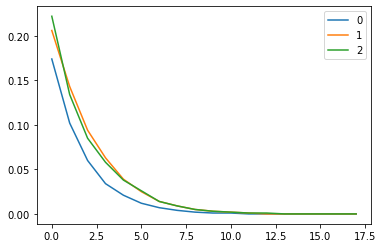

In [25]:
for ii in range(3):
    _, median, _ = lmus_p[(ii, 'p_u_lfi')]
    plt.plot(median, label=ii)
    print(median)
plt.legend()

[0.315  0.243  0.1885 0.15   0.117  0.0855 0.067  0.047  0.038  0.026
 0.02   0.013  0.01   0.006  0.005  0.003  0.002  0.001 ]
[0.2295 0.19   0.131  0.089  0.057  0.037  0.019  0.011  0.006  0.004
 0.002  0.001  0.     0.     0.     0.     0.     0.    ]
[0.071 0.021 0.004 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]


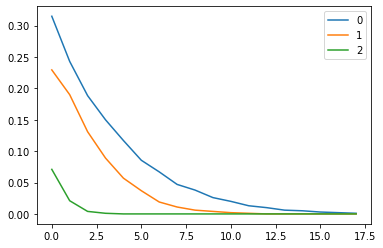

In [26]:
for ii in range(3):
    _, median, _ = lmus_p[(ii, 'p_fa_lfi')]
    plt.plot(median, label=ii)
    print(median)
plt.legend()